# Second Request

### import libraries

In [2]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### connect to database


In [3]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="123456",
    database="booktopia"
)
print(mydb)

In [4]:
mycursor = mydb.cursor()
mycursor.execute("""

SELECT
    book_detail.site_id,
    book_detail.English_title,
    book_detail.score,
    book_detail.edition,
    book_detail.stock_status,
    book_detail.ad_publication_year,
    book_detail.solar_publication_year,
    price_history.price,
    rewards.reward
FROM
    book_detail
JOIN
    price_history ON book_detail.site_id = price_history.book_id
JOIN
    rewards ON book_detail.site_id = rewards.site_id
WHERE
    book_detail.stock_status = ' موجود ';
"""
                 )

myresult = mycursor.fetchall()

### create and filter 20% of lowest price of books

In [5]:
df = pd.DataFrame(myresult, columns=[i[0] for i in mycursor.description])
df

,site_id,English_title,score,edition,stock_status,ad_publication_year,solar_publication_year,price,reward
0,14025,the reivers,3.79,5,موجود,1962,1401,185000,برنده ی جایزه ی پولیتزر سال ۱۹۶۳
1,1806,Life 3.0: Being Human in the Age of Artificia...,4.10,8,موجود,2017,1401,290000,از پرفروش ترین کتاب های نیویورک تایمز
2,1806,Life 3.0 : being human in the age of artifici...,3.35,1,موجود,2017,1401,290000,از پرفروش ترین کتاب های نیویورک تایمز
3,6580,Collected Poems,3.15,-1,موجود,-1,1394,35000,رودکی مشهور به استاد شاعران، نخستین شاعر مشه...
4,63869,Running Out of Time,3.03,3,موجود,1995,1402,125000,نامزد جایزه کتاب ناشر مستقل سال 1999
...,...,...,...,...,...,...,...,...,...
13373,56860,Popo reads a book he knows the value of it,3.65,-1,موجود,2019,1398,35000,تصویرگر: امیر حامد پاژتار
13374,56860,Popo reads a book he knows the value of it,3.44,-1,موجود,2019,1398,35000,تصویرگر: امیر حامد پاژتار
13375,1525,The Festival of Insignificance,3.49,13,موجود,2013,1402,15000,میلان کوندرا، نامزد جایزه نوبل ادبیات و از پ...
13376,1525,The Festival of Insignificance,3.32,2,موجود,2013,1401,15000,میلان کوندرا، نامزد جایزه نوبل ادبیات و از پ...


In [6]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
price_threshold = df['price'].quantile(0.2)
cheapest_books = df[df['price'] <= price_threshold]
df = cheapest_books
df.reset_index(drop=True, inplace=True)

### normalize fetchers

In [7]:
df = df.groupby('site_id').agg(
    {'score': 'first', 'edition': 'first', 'ad_publication_year': 'first', 'reward': 'count', 'English_title': 'first'})
df

,score,edition,ad_publication_year,reward,English_title
site_id,,,,,
28,3.60,3,2011,1,The Buddha in the Attic
33,3.50,6,2005,4,The Sea
40,3.18,1,2006,1,The Road
47,3.16,14,2015,3,Fish in a Tree
51,3.61,2,2006,1,Red April
...,...,...,...,...,...
103845,3.94,1,-1,1,Nejat Dahande
116447,3.75,1,-1,4,Days in the history of silence
117054,3.46,2,1989,2,The seat of the soul


In [8]:
normalized_reward = df.groupby('site_id').count()['reward']
max_reward = normalized_reward.quantile(0.9)
normalized_reward = normalized_reward / max_reward
normalized_reward[normalized_reward > 1] = 1
normalized_reward[normalized_reward < 0] = 0

In [9]:
normalized_score = (df['score'] / 5).astype('float64')

In [10]:
normalized_edition = df['edition'] / (2024 - df['ad_publication_year']) * 2
max_edition = normalized_edition.quantile(0.9)
normalized_edition = normalized_edition / max_edition
normalized_edition[normalized_edition > 1] = 1
normalized_edition[normalized_edition < 0] = 0

### See results of the top 10 books

In [11]:
df['Books_score'] = ((normalized_edition * 0.3) + (normalized_score * 0.2) + normalized_reward * 0.5)
df = df.sort_values(by='Books_score', ascending=False)
top_books = df.head(10)
top_books

,score,edition,ad_publication_year,reward,English_title,Books_score
site_id,,,,,,
1983,4.75,26,1971,1,Reunion,0.985455
1127,4.56,17,2017,2,Dear Ijeawele,0.982400
1331,4.46,12,2014,2,We Should All Be Feminists,0.978400
1111,4.28,6,2015,2,Boats for Papa,0.971200
666,4.22,101,1958,2,Bear Called Paddington,0.968800
14343,4.05,7,2012,2,Code Name Verity,0.962000
12719,4.02,15,2018,1,When Never Comes,0.960800
58134,3.99,3,2019,1,What If Everybody Thought That?,0.959600
1507,3.98,10,2006,2,The Boy in the Striped Pyjamas,0.959200


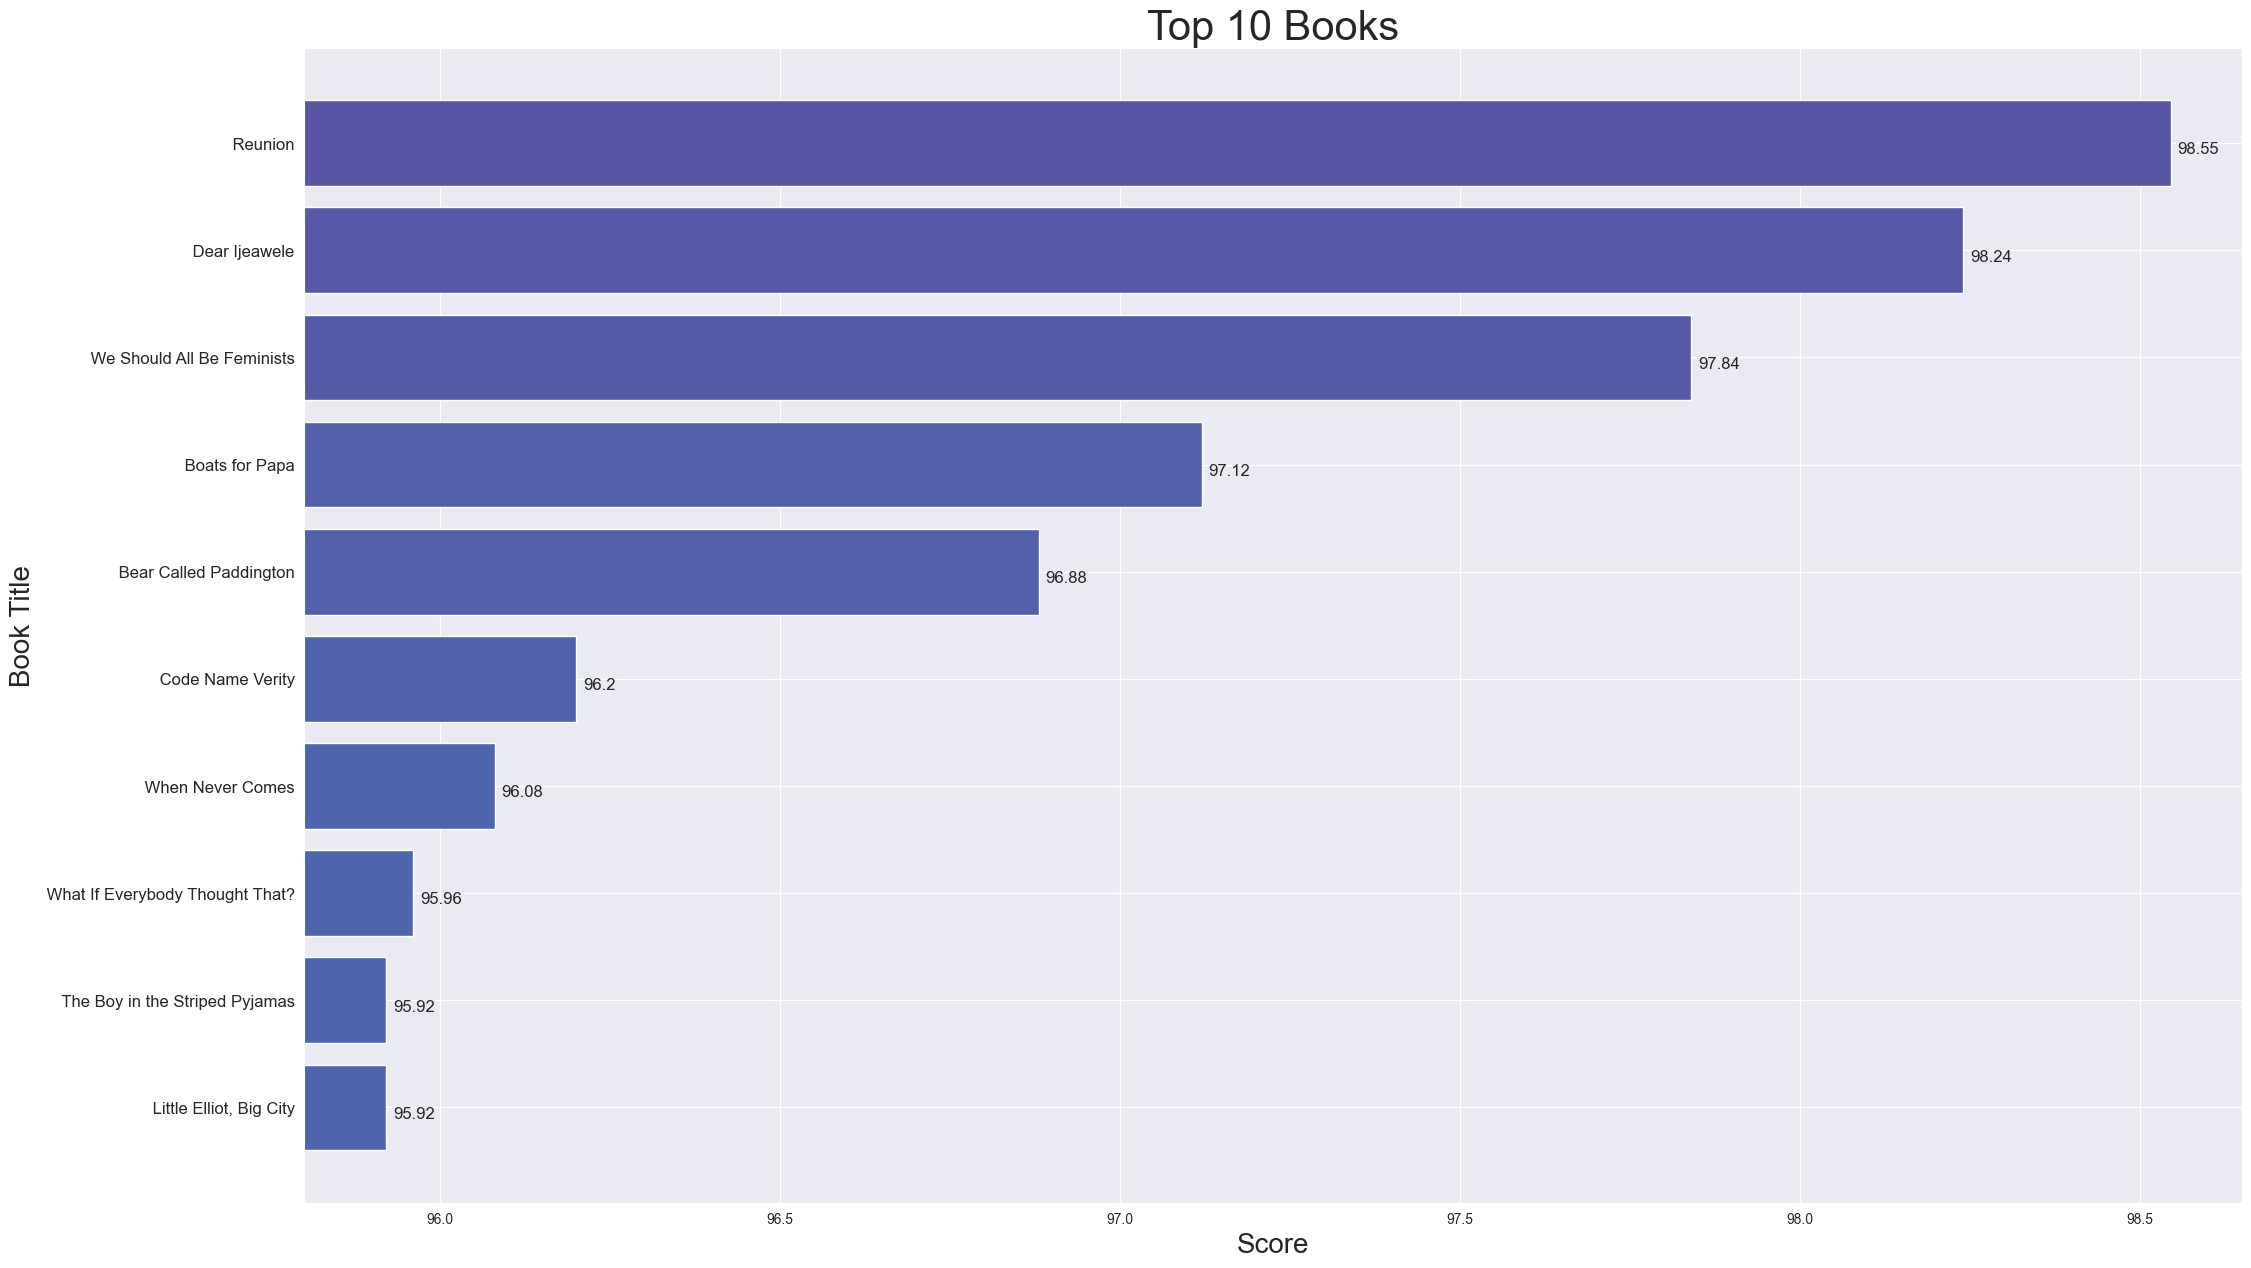

In [12]:
sns.set_style("darkgrid")

cmap = plt.get_cmap('Spectral')
colors = cmap(np.array(top_books['Books_score'] * 100) / 100)
fig, ax = plt.subplots(figsize=(25, 15))
bar_plot = ax.barh(top_books['English_title'], top_books['Books_score'] * 100, color=colors)
for i in ax.patches:
    plt.text(i.get_width() + 0.01, i.get_y() + 0.5, str(round(i.get_width(), 2)), fontsize=12)
ax.set_xlabel('Score', fontsize=20)
ax.set_ylabel('Book Title', fontsize=20)
ax.set_title('Top 10 Books', fontsize=30)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlim([95.8, 98.65])
ax.invert_yaxis()
plt.show()